In [21]:
import pandas as pd
import numpy as np

df = pd.read_parquet("/home/niclas/ATOW-Prediction/additional_data/T100_data/t100_segment_data.parquet")
aircraft_types = pd.read_csv("/home/niclas/ATOW-Prediction/additional_data/T100_data/L_AIRCRAFT_TYPE.csv")

In [22]:
challenge_data = pd.read_csv("data/challenge_set.csv")

In [23]:
aircraft_types.rename(columns={"Code": "AIRCRAFT_TYPE", "Description": "Aircraft_Name"}, inplace=True)
df = df.merge(aircraft_types)


In [24]:
df.columns

Index(['DEPARTURES_SCHEDULED', 'DEPARTURES_PERFORMED', 'PAYLOAD', 'SEATS',
       'PASSENGERS', 'FREIGHT', 'MAIL', 'DISTANCE', 'RAMP_TO_RAMP', 'AIR_TIME',
       'UNIQUE_CARRIER', 'AIRLINE_ID', 'UNIQUE_CARRIER_NAME',
       'UNIQUE_CARRIER_ENTITY', 'REGION', 'CARRIER', 'CARRIER_NAME',
       'CARRIER_GROUP', 'CARRIER_GROUP_NEW', 'ORIGIN_AIRPORT_ID',
       'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN',
       'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS',
       'ORIGIN_STATE_NM', 'ORIGIN_COUNTRY', 'ORIGIN_COUNTRY_NAME',
       'ORIGIN_WAC', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID',
       'DEST_CITY_MARKET_ID', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR',
       'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_COUNTRY', 'DEST_COUNTRY_NAME',
       'DEST_WAC', 'AIRCRAFT_GROUP', 'AIRCRAFT_TYPE', 'AIRCRAFT_CONFIG',
       'YEAR', 'QUARTER', 'MONTH', 'DISTANCE_GROUP', 'CLASS', 'DATA_SOURCE',
       'Aircraft_Name'],
      dtype='object')

In [25]:
df["LOAD_FACTOR"] = df["PASSENGERS"] / df["SEATS"]
df = df[(df["DEPARTURES_PERFORMED"] > 0) &
        (df["DEPARTURES_SCHEDULED"] > 0) &
         (df["SEATS"] > 0) &
         (df["AIRCRAFT_CONFIG"] == 1) &
         (df["FREIGHT"] == 0) &
         (df["MAIL"] == 0) &
         (df["AIR_TIME"] > 0) &
         (df["RAMP_TO_RAMP"] > 0) &
         (df["DISTANCE"] > 0) & 
         (df["LOAD_FACTOR"] <= 1) &
         (df["LOAD_FACTOR"] > 0) &
         (df["DEPARTURES_PERFORMED"] <= df["DEPARTURES_SCHEDULED"])
]

<Axes: >

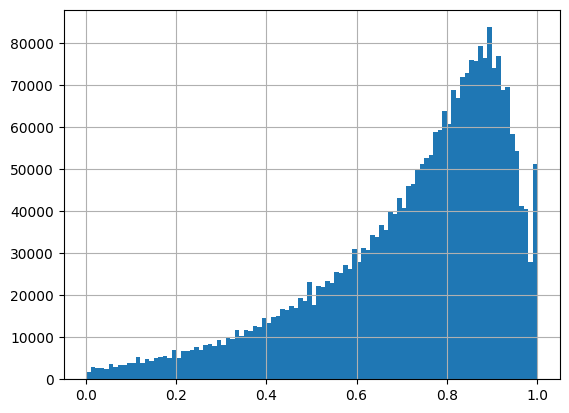

In [26]:
df["LOAD_FACTOR"].hist(bins=100)

In [27]:
challenge_data["aircraft_type"].unique()

array(['A320', 'B772', 'A333', 'B788', 'A21N', 'A20N', 'B738', 'B789',
       'A321', 'CRJ9', 'A319', 'B77W', 'BCS3', 'AT76', 'E190', 'B763',
       'BCS1', 'E195', 'B38M', 'B739', 'B737', 'A359', 'A332', 'B39M',
       'A343', 'A310', 'B752', 'B773', 'C56X', 'E290'], dtype=object)

In [28]:
mapping = {
    "A320": "Airbus Industrie A320-100/200",
    "B738": "Boeing 737-800",
    "B739": "Boeing 737-900",
    'B772': "Boeing 777-200ER/200LR/233LR",
    'A333': "Airbus Industrie A330-300/333",
    'B788': "B787-800 Dreamliner",
    'A21N': "Airbus Industrie A321-200n",
    'A20N': "Airbus Industrie A320-200n",
    'B789': "B787-900 Dreamliner",
    'A321': "Airbus Industrie A321/Lr",
    'CRJ9': "Canadair CRJ 900",
    'A319': "Airbus Industrie A319",
    'B77W': "Boeing 777-300/300ER/333ER",
    'BCS3': "A220-300 BD-500-1A11",
    'AT76': "Aerospatiale/Aeritalia ATR-72",
    'E190': "Embraer 190",
    'B763': "Boeing 767-300/300ER",
    'BCS1': "A200-100 BD-500-1A10",
    'E195': "Embraer EMB195",
    'B38M': "Boeing B737 Max 800",
    'B737': "Boeing 737-700/700LR/Max 7",
    'A359': "Airbus Industrie A350-900",
    'A332': "Airbus Industrie A330-200",
    'B39M': "Boeing B737 Max 900",
    'A343': "Airbus Industrie A340-300",
    'A310': "Airbus Industrie A310-300",
    'B752': "Boeing 757-200",
    'B773': "Boeing 777-300/300ER/333ER",
    'C56X': "Cessna Citation X Model 650/550B/550XL",
    'E290': "Embraer ERJ-175",  # Note: This is the closest match, as E290 is not explicitly listed in the provided data
}
challenge_data["aircraft_type"].unique()
df["Aircraft_Name"].value_counts()

Aircraft_Name
Canadair RJ-200ER /RJ-440                    312614
Airbus Industrie A320-100/200                271730
Canadair RJ-700                              222169
Embraer-145                                  217692
Embraer ERJ-175                              212855
                                              ...  
Beech 65/65A-80/65B-80 (Queen Air)                1
Pilatus Britten-Norman BN2A Trislander            1
Beech Bonanza 35A/C/D/E/G/H/J/K/S/V/  36A         1
Cessna C-310 Series                               1
Bombardier BD-100-1A10 Challenger 300             1
Name: count, Length: 156, dtype: int64

In [29]:
df = df[df["Aircraft_Name"].isin(mapping.values())]
df = df[df["YEAR"].isin([2022, 2023, 2019, 2018])]

In [30]:
repeated_indices = np.repeat(df.index.values, df['DEPARTURES_PERFORMED'])    
# Use the repeated indices to create the new dataframe
df = df.loc[repeated_indices].reset_index(drop=True)

for col in ["AIR_TIME", "DISTANCE", "SEATS", "RAMP_TO_RAMP", "PAYLOAD"]:
    df[col] = df[col] / df["DEPARTURES_PERFORMED"]

In [31]:
feature_cols = [
    "Aircraft_Name",
    "PAYLOAD", # target
    "AIR_TIME",
    "DISTANCE",
    "SEATS",
    "MONTH",
    "LOAD_FACTOR", # => Can vary later
    "RAMP_TO_RAMP", #  - 2x taxiout?
]

df = df[feature_cols]

In [32]:
def filter_outliers(df, n=2):
    return df[(df - df.mean()).abs() < n * df.std()]

filter_cols = ["PAYLOAD", "AIR_TIME", "RAMP_TO_RAMP", "DISTANCE", "SEATS"]
min_max = {}
for col in filter_cols:
    filtered = filter_outliers(df[col])
    min_max[col] = [filtered.min(), filtered.max()]

for col, (min, max) in min_max.items():
    df = df[(df[col] >= min) & (df[col] <= max)]

In [33]:
min_max

{'PAYLOAD': [5450.0, 53160.0],
 'AIR_TIME': [6.0, 240.80645161290323],
 'RAMP_TO_RAMP': [19.0, 268.6923076923077],
 'DISTANCE': [0.3058103975535168, 296.8181818181818],
 'SEATS': [38.0, 222.0]}

<Axes: >

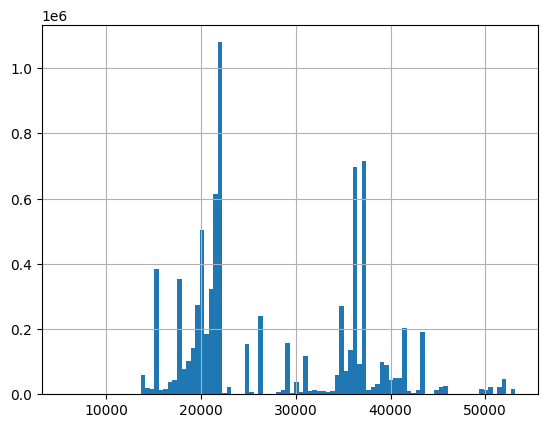

In [34]:
df["PAYLOAD"].hist(bins=100)

In [35]:
df["aircraft_type"] = df["Aircraft_Name"].map({v:k for k,v in mapping.items()})
df.drop(columns=["Aircraft_Name"], inplace=True)
df

,PAYLOAD,AIR_TIME,DISTANCE,SEATS,MONTH,LOAD_FACTOR,RAMP_TO_RAMP,aircraft_type
4,14000.0,29.000000,96.000000,70.0,10,0.900000,61.000000,E290
10,15200.0,9.000000,30.000000,76.0,10,0.157895,53.000000,E290
11,15200.0,31.000000,150.000000,76.0,10,0.223684,59.000000,CRJ9
12,15200.0,22.000000,65.000000,76.0,10,0.236842,36.000000,CRJ9
15,15200.0,35.000000,196.000000,76.0,10,0.342105,67.000000,E290
...,...,...,...,...,...,...,...,...
9153209,25000.0,77.546835,1.010127,100.0,2,0.502127,103.729114,E190
9153210,25000.0,77.546835,1.010127,100.0,2,0.502127,103.729114,E190
9153211,25000.0,77.546835,1.010127,100.0,2,0.502127,103.729114,E190
9153212,25000.0,77.546835,1.010127,100.0,2,0.502127,103.729114,E190


In [36]:
df.to_parquet("additional_data/T100_data/dataset.parquet")